# Comparing total hydrostatic masses measured by LoCuSS and XGA

This notebook measures hydrostatic masses for the samples we are using to verify our method, then compares them to the measurements from literature. These mass measurements include both the baryonic content of the intra-cluster medium, and that of the dark matter halo. This implicitly tests how close our measured temperature and density profiles are to those measured by the work we compare them to

The LoCuSS sample has hydrostatic mass measurements associated with them which we will compare to but the XXL-100-GC sample data is generally too shallow for such measurements.

## Import Statements

In [1]:
import pandas as pd
import numpy as np
from astropy.units import Quantity, UnitConversionError, Unit
import matplotlib.pyplot as plt
from typing import Union, List
from shutil import rmtree
import os
from tqdm import tqdm

# This adds the directory above to the path, allowing me to import the common functions that I've written in
#  common.py - this just saves me repeating boring code and makes sure its all consistent
import sys
sys.path.insert(0, '..')
from common import locuss_colour, locuss_cosmo, direct_comparison_plot, find_lims, fit_comp

import xga
# This just sets the number of cores this analysis is allowed to use
xga.NUM_CORES = 100
# This is a bodge that will only work because xga_output in notebooks has already been defined, XGA
#  will be made to handle this more gracefully at some point
temp_dir = xga.OUTPUT
actual_dir = temp_dir.split('notebooks/')[0]+'notebooks/xga_output/'
xga.OUTPUT = actual_dir
xga.utils.OUTPUT = actual_dir
# As currently XGA will setup an xga_output directory in our current directory, I remove it to keep it all clean
if os.path.exists('xga_output'):
    rmtree('xga_output')
from xga.samples import ClusterSample
from xga.sourcetools.mass import inv_abel_dens_onion_temp
from xga.models import DoubleBetaProfile1D, SimpleVikhlininDensity1D, SimpleVikhlininTemperature1D

## Reading in Sample Files and Declaring XGA ClusterSamples

This subsection involves reading in the sample files of the four test samples (described in [the sample properties notebook](sample_properties.ipynb)), then setting up separate XGA ClusterSample instances (see [the documentation](https://xga.readthedocs.io/en/latest/notebooks/tutorials/sources_samples.html) for an introduction to XGA source and sample objects.

We impose an additional cleaning step on each sample, where we make sure that (for each XMM observation initially associated with a source) at least 70% of a cluster's $R_{500}$ falls on that observation - if this requirement is not met then the observation is excluded. These requirements are set with the `clean_obs=True`, `clean_obs_reg='r500'`, and `clean_obs_threshold=0.7` arguments when a ClusterSample instance is declared.

### LoCuSS High-$L_{\rm{X}}$

The LoCuSS High-$L_{\rm{X}}$ sample was selected from ROSAT for its high luminosity clusters, and will again be a useful comparison as testing against various different analyses is beneficial in establishing the veracity of our new measurements.

In [2]:
locuss = pd.read_csv("../../sample_files/locuss_highlx_clusters.csv", dtype={'chandra_id': str, 'xmm_obsid': str})

In [3]:
# Reading out the relevant values into arrays just for ease of passing into the ClusterSample object
ra = locuss['ra'].values
dec = locuss['dec'].values
z = locuss['z'].values
n = locuss['name'].values
r500 = Quantity(locuss['r500'].values, 'kpc')
r2500 = Quantity(locuss['r2500'].values, 'kpc')

# Declaring the actual ClusterSample instance for the LoCuSS sample
locuss_srcs = ClusterSample(ra, dec, z, n, r500=r500, r2500=r2500, cosmology=locuss_cosmo, load_fits=True, 
                            use_peak=False, clean_obs=True, clean_obs_reg='r500', clean_obs_threshold=0.7)

Declaring BaseSource Sample:  36%|███████████████▊                            | 18/50 [00:37<01:09,  2.18s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/base.py:90: UserWarning: Source ZwCl0949.6+5207 does not appear to have any XMM data, and will not be included in the sample.
  warn("Source {n} does not appear to have any XMM data, and will not be included in the "
Declaring BaseSource Sample:  46%|████████████████████▏                       | 23/50 [00:46<00:57,  2.14s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/base.py:90: UserWarning: Source Abell1423 does not appear to have any XMM data, and will not be included in the sample.
  warn("Source {n} does not appear to have any XMM data, and will not be included in the "
Declaring BaseSource Sample:  54%|███████████████████████▊                    | 27/50 [00:51<00:37,  1.64s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/base.py:90: UserWarning: Source Abell1682 does not appear to have any XMM data, and

## Reading in literature data

###   $\color{red}{\text{Hydrostatic masses from literature}}$

In [4]:
loc_lit_m500s = [locuss[locuss['name'] == n].iloc[0][['x_m500', 'x_m500_err', 'x_m500_err']].values
               for n in locuss_srcs.names]
loc_lit_m500s = Quantity(loc_lit_m500s, 'Msun')

loc_lit_m2500s = [locuss[locuss['name'] == n].iloc[0][['x_m2500', 'x_m2500_err', 'x_m2500_err']].values
               for n in locuss_srcs.names]
loc_lit_m2500s = Quantity(loc_lit_m2500s, 'Msun')

## Hydrostatic Mass Comparison to Literature

### Double Beta and Simplified Vikhlinin Density/Temperature Profiles - out to 1.3$R_{500}$

In [5]:
demo_sb_mod = DoubleBetaProfile1D()
demo_sb_mod.info()
demo_sb_mod.par_priors

╒═══════════════════════╤════════════════════════════════════════════════════════════════════════════╕
│ Double Beta Profile   │                                                                            │
╞═══════════════════════╪════════════════════════════════════════════════════════════════════════════╡
│ DESCRIBES             │ Surface Brightness                                                         │
├───────────────────────┼────────────────────────────────────────────────────────────────────────────┤
│ UNIT                  │ ct / (arcmin2 s)                                                           │
├───────────────────────┼────────────────────────────────────────────────────────────────────────────┤
│ PARAMETERS            │ beta_one, r_core_one, norm_one, beta_two, r_core_two, norm_two             │
├───────────────────────┼────────────────────────────────────────────────────────────────────────────┤
│ PARAMETER UNITS       │ , kpc, ct / (arcmin2 s), , kpc, ct / (arcmin2 s

[{'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [1.e+00, 2.e+03] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.] ct / (arcmin2 s)>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [1.e+00, 2.e+03] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.] ct / (arcmin2 s)>, 'type': 'uniform'}]

In [6]:
demo_d_mod = SimpleVikhlininDensity1D(y_unit=Unit("1 / cm^3"))
demo_d_mod.info()
demo_d_mod.par_priors

╒════════════════════════════════╤═══════════════════════════════════════════════════════════════════════╕
│ Simplified Vikhlinin Profile   │                                                                       │
╞════════════════════════════════╪═══════════════════════════════════════════════════════════════════════╡
│ DESCRIBES                      │ Gas Density                                                           │
├────────────────────────────────┼───────────────────────────────────────────────────────────────────────┤
│ UNIT                           │ 1 / cm3                                                               │
├────────────────────────────────┼───────────────────────────────────────────────────────────────────────┤
│ PARAMETERS                     │ beta, r_core, alpha, r_s, epsilon, norm                               │
├────────────────────────────────┼───────────────────────────────────────────────────────────────────────┤
│ PARAMETER UNITS                │ , 

[{'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [   0., 2000.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [   0., 2000.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 5.]>, 'type': 'uniform'},
 {'prior': <Quantity [ 0., 10.] 1 / cm3>, 'type': 'uniform'}]

In [7]:
demo_t_mod = SimpleVikhlininTemperature1D()
demo_t_mod.info()
demo_t_mod.par_priors

╒════════════════════════════════╤═════════════════════════════════════════════════════════════════════╕
│ Simplified Vikhlinin Profile   │                                                                     │
╞════════════════════════════════╪═════════════════════════════════════════════════════════════════════╡
│ DESCRIBES                      │ Gas Temperature                                                     │
├────────────────────────────────┼─────────────────────────────────────────────────────────────────────┤
│ UNIT                           │ keV                                                                 │
├────────────────────────────────┼─────────────────────────────────────────────────────────────────────┤
│ PARAMETERS                     │ r_cool, a_cool, t_min, t_zero, r_tran, c_power                      │
├────────────────────────────────┼─────────────────────────────────────────────────────────────────────┤
│ PARAMETER UNITS                │ kpc, , keV, keV, kpc

[{'prior': <Quantity [   0., 2000.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [-10.,  10.]>, 'type': 'uniform'},
 {'prior': <Quantity [ 0., 15.] keV>, 'type': 'uniform'},
 {'prior': <Quantity [ 0., 15.] keV>, 'type': 'uniform'},
 {'prior': <Quantity [   0., 2000.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [-10.,  10.]>, 'type': 'uniform'}]

In [8]:
loc_sb_dblbeta_simpvikh_13_mp = inv_abel_dens_onion_temp(locuss_srcs, locuss_srcs.r500*1.3, 'double_beta', 
                                                         'simple_vikhlinin_dens', 'simple_vikhlinin_temp', 'r500', 
                                                         temp_min_snr=30, freeze_met=False, 
                                                         temp_lo_en=Quantity(0.7, 'keV'), 
                                                         temp_hi_en=Quantity(10., 'keV'))

Generating products of type(s) spectrum: 100%|████████████████████████████| 216/216 [1:51:28<00:00, 30.97s/it]
Generating products of type(s) annular spectrum set components: 100%|███| 2823/2823 [2:58:01<00:00,  3.78s/it]
Running XSPEC Fits: 100%|█████████████████████████████████████████████████| 589/589 [1:00:24<00:00,  6.15s/it]
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/xspec/run.py:326: UserWarning: Abell0697 annular spectra profile fit was not successful
  warnings.warn("{src} annular spectra profile fit was not successful".format(src=ann_spec.src_name))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/xspec/run.py:326: UserWarning: Abell0773 annular spectra profile fit was not successful
  warnings.warn("{src} annular spectra profile fit was not successful".format(src=ann_spec.src_name))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/xspec/run.py:326: UserWarning: Abell0963 annular spectra profile fit was not successful
  warnings.warn("{src} annular spectra profile fit was not succe

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [852.92720946 604.58734008 809.35886196 727.34446792 771.42108757
 809.98865848]


Fitting data, inverse Abel transforming, and measuring densities:   6%|▍       | 2/35 [00:51<14:10, 25.78s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1524.93155055  723.59590918 1724.11750429 1578.22695653 1726.5263454
 1687.95368965]


Fitting data, inverse Abel transforming, and measuring densities:   9%|▋       | 3/35 [01:15<13:18, 24.95s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 715.78009966 1343.04423225 1322.95045421 1383.34270435 1470.55701999
 1621.00512908]


Fitting data, inverse Abel transforming, and measuring densities:  11%|▉       | 4/35 [01:40<12:53, 24.96s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [232.06324806 434.39859945 116.32974499 163.91059152 323.97896698
 370.64768722]


Fitting data, inverse Abel transforming, and measuring densities:  14%|█▏      | 5/35 [02:06<12:34, 25.17s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [132.70729431 458.52823998 484.6111733  428.59669104 460.45735634
 534.93428005]


Fitting data, inverse Abel transforming, and measuring densities:  17%|█▎      | 6/35 [02:34<12:35, 26.06s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 473.22063587  165.35558397 2031.99343115 1942.9239707  1992.06238767
 1924.49341235]


Fitting data, inverse Abel transforming, and measuring densities:  26%|██      | 9/35 [03:58<11:57, 27.60s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [307.96337815 392.76749103 571.05227502 210.36301261 255.12204192
 368.07567564]


Fitting data, inverse Abel transforming, and measuring densities:  34%|██▍    | 12/35 [05:15<10:09, 26.50s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1481.71331857  601.70280671 1228.75456927 1371.75202619 1436.17671874
 1583.06317147]


Fitting data, inverse Abel transforming, and measuring densities:  37%|██▌    | 13/35 [05:42<09:46, 26.66s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [557.65010534 536.13735246 369.45314963 395.5525386  432.93585798
 514.21122394]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [166.73931637 223.89047262 551.26299721 184.683868   169.79160143
 151.78472469]


Fitting data, inverse Abel transforming, and measuring densities:  43%|███    | 15/35 [06:30<08:22, 25.12s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1397.58246638  509.99757244 1842.71045977  792.62921818  834.38472304
 1836.39199087]


Fitting data, inverse Abel transforming, and measuring densities:  54%|███▊   | 19/35 [08:18<06:52, 25.77s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1557.17825932  730.09105996 1593.83171923  927.6142249   837.78972002
 1588.43058545]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 891.3551852  1514.1458202  1559.72492695  784.91471025 1492.46131773
 1546.38323085]


Fitting data, inverse Abel transforming, and measuring densities:  60%|████▏  | 21/35 [09:16<06:28, 27.76s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1796.08374663  281.46549386 1945.66228933  505.77986773  517.76383446
 1943.04791097]


Fitting data, inverse Abel transforming, and measuring densities:  74%|█████▏ | 26/35 [11:32<04:04, 27.20s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 880.12535292  616.46695328 1666.87878381 1413.34205308 1331.03652773
 1646.45237723]


Fitting data, inverse Abel transforming, and measuring densities:  80%|█████▌ | 28/35 [12:28<03:15, 27.86s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [260.95193789 505.4025411  504.52661223 545.34988575 567.97868482
 513.82886599]


Fitting data, inverse Abel transforming, and measuring densities:  97%|██████▊| 34/35 [15:21<00:28, 28.31s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [767.63082149 448.166266   862.7116775  546.39930759 671.76346904
 949.58356955]


Fitting data, inverse Abel transforming, and measuring densities: 100%|███████| 35/35 [15:48<00:00, 27.11s/it]


The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [583.26223668 586.3938834  536.39736155 364.94268786 438.90061436
 549.37872957]


Generating Abell2697 hydrostatic mass profile:   0%|                                   | 0/46 [00:00<?, ?it/s]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 839.7097567  1151.31893782  783.78585707  746.3126659   925.93049858
  515.58965954]


Generating Abell2813 hydrostatic mass profile:   4%|█▏                         | 2/46 [00:50<36:46, 50.14s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [318.32568764 568.35239713 296.68393282 368.75064318 372.25154541
 342.15599822]


Generating Abell0115S hydrostatic mass profile:   7%|█▋                        | 3/46 [01:39<22:23, 31.25s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1521: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [395.58557792 775.69120974 638.58533165 816.5932746  391.96120158
 491.87027578]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 98.97464149 121.33618707 609.11123666 103.48647241 109.36975702
 299.89754639]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1521: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating Abell141 hydrostatic mass profile:   9%|██▍                         | 4/46 [02:29<26:23, 37.70s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [760.2575218  811.86857979 637.46614246 724.79084403 983.42812154
 615.39306441]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [129.5619798  314.96498434 661.46506293 118.22538306  57.59296331
 316.15787492]


Generating ZwCl0104.4+0048 hydrostatic mass profile:  11%|██▎                  | 5/46 [03:17<28:14, 41.32s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1504.39641236 1825.29993776 1142.05598184  821.73547066 2115.67078918
  903.05027052]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 104.00805918  108.47970148 1082.75418872  114.25984562  117.96512863
  105.91778621]


Generating Abell0209 hydrostatic mass profile:  13%|███▌                       | 6/46 [04:05<28:46, 43.17s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1521: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [430.92687583 823.63079278 551.17999469 554.77535164 418.85661898
 547.75747587]
The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 558.66869313 1034.88927832 1288.27770195  382.38884284  552.89852339
 1185.16377553]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1521: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating Abell0267 hydrostatic mass profile:  15%|████                       | 7/46 [04:58<30:06, 46.31s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1010: UserWarning: Optimal parameters not found: The maximum number of function evaluations is exceeded., curve_fit has failed.
  warn("{}, curve_fit has failed.".format(str(r_err)))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/models/temperature.py:109: RuntimeWarning: overflow encountered in power
  cool_expr = ((t_min / t_zero) + (x / r_cool)**a_cool) / (1 + (x / r_cool)**a_cool)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/models/temperature.py:109: RuntimeWarning: invalid value encount

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 375.5025624  1018.38284948  426.24152314  406.27482972  334.5654855
  346.90377225]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 97.31132962  99.41235833 844.53266253 102.29155116 119.54122686
 101.65425195]


Generating Abell0291 hydrostatic mass profile:  17%|████▋                      | 8/46 [05:48<30:05, 47.51s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1521: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 999.9006521  1739.31299605 1359.88937766 1622.52833006 1116.73177893
  637.10660899]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [100.66355502  93.66863005 423.06965449 104.55486576 118.29266394
  92.5487249 ]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1521: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating Abell0383 hydrostatic mass profile:  20%|█████▎                     | 9/46 [06:37<29:37, 48.05s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 900.5231587  1112.75196844  565.55239455  806.03267017 1001.38857027
  607.2809227 ]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 81.576299    85.96256661 813.84399593  75.10223666  72.99893214
  90.70025534]


Generating Abell0521 hydrostatic mass profile:  22%|█████▋                    | 10/46 [07:30<29:42, 49.50s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1010: UserWarning: Optimal parameters not found: The maximum number of function evaluations is exceeded., curve_fit has failed.
  warn("{}, curve_fit has failed.".format(str(r_err)))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:810: UserWarning: Maximum likelihood estimator has produced at least one start parameter that is outside the allowed values defined by the prior, reverting to default start parameters for this model.
  warn("Maximum likelihood estimator has produced at least one start parameter that is outside"


The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [371.496003   684.83351962 417.85458407 424.87929639 449.20830341
 409.22736407]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1652.96294308 1953.9898163  1378.75907148 1894.63216214 1642.3664837
 1512.08042449]


Generating Abell0586 hydrostatic mass profile:  24%|██████▏                   | 11/46 [08:20<29:01, 49.76s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1521: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [338.15735611 865.17368186 407.37574629 493.68829757 366.30590874
 371.36973644]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1521: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating Abell0611 hydrostatic mass profile:  26%|██████▊                   | 12/46 [09:11<28:23, 50.12s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 425.11912702 1124.76003668  454.16894595  633.16867253  391.66833944
  380.77044145]
The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [430.58964414 560.07591925 713.65300761 332.14274218 182.19974141
 616.016835  ]


Generating ZwCl0857.9+2107 hydrostatic mass profile:  30%|██████              | 14/46 [10:00<26:33, 49.80s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1521: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1521: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating Abell0750 hydrostatic mass profile:  33%|████████▍                 | 15/46 [10:54<20:13, 39.15s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 98.56271421 106.16206726 510.44788848  97.2575172  125.30356182
 108.24780308]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 916.72970039 1745.44442981 1595.89226762 1765.55832277  819.45721312
 1042.71438323]
The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [582.56297241 499.70535493 273.82427702 522.34127597 219.49226452
 260.68757684]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1521: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating Abell0781 hydrostatic mass profile:  37%|█████████▌                | 17/46 [11:41<19:54, 41.20s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1405.57078112 1600.51664802 1632.22149641 1451.35167645  655.5751916
 1032.34025875]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1491.17044459 1472.13280294  664.36055566  907.49262726 1426.38724356
  857.09899238]


Generating Abell0901 hydrostatic mass profile:  39%|██████████▏               | 18/46 [12:30<15:55, 34.14s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1521: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 888.7128671  1127.60122652  580.47547143  829.16185401  596.19728305
  585.79651214]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 84.28426045  82.5184865  638.87022175  79.3672719   78.35234046
  79.72932028]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1521: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating Abell0907 hydrostatic mass profile:  41%|██████████▋               | 19/46 [13:22<17:14, 38.30s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [403.7154674  386.21064128 177.50178468 267.69597064 227.90410754
 197.82311655]


Generating ZwCl1021.0+0426 hydrostatic mass profile:  46%|█████████▏          | 21/46 [14:17<17:41, 42.47s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [405.84341655 391.65656351 248.06194911 487.62318861 249.38148991
 187.98362115]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 90.7597824  102.3489486  846.03576622  62.38107052  79.83080501
  65.05953442]


Generating RXCJ1212.3-1816 hydrostatic mass profile:  50%|██████████          | 23/46 [15:10<13:41, 35.73s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [521.59731176 783.87786582 585.55871255 587.21864947 683.51418579
 545.3598277 ]


Generating ZwCl1231.4+1007 hydrostatic mass profile:  52%|██████████▍         | 24/46 [15:54<11:17, 30.77s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [825.61984022 863.78903678 367.62114976 823.45376991 433.6682948
 418.11288766]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1521: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1554.168846   1629.376052   2292.65594597 1798.7855324   706.91013182
 1586.36021904]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1521: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating Abell1689 hydrostatic mass profile:  54%|██████████████▏           | 25/46 [16:45<12:13, 34.92s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1574.36323165 1825.70788955 1589.49124881 2042.77329411  600.9880939
 1662.60527167]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [100.36900928  98.6505144  460.03697743 102.27060855  67.72031672
  95.01590924]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1521: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating Abell1758N hydrostatic mass profile:  57%|██████████████▏          | 26/46 [17:40<13:10, 39.53s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 793.92592121 1250.63450387  942.73105084 1171.47554667  674.57141822
 1122.84869655]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [930.5728225  933.92951926 444.78498451 797.75580364 765.73878878
 510.15524668]


Generating Abell1835 hydrostatic mass profile:  61%|███████████████▊          | 28/46 [18:28<12:30, 41.71s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [669.33129205 840.72646678 630.40149374 672.32272677 248.71536327
 310.03086953]


Generating ZwCl1454.8+2233 hydrostatic mass profile:  65%|█████████████       | 30/46 [19:24<09:36, 36.02s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1749.21544651 1787.68429046 1270.14347059 1497.31270452 2055.39047051
 1637.58853638]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [  93.25659392   96.26266679 1292.83576024  108.07696024  119.65461486
   98.11252818]


Generating Abell2009 hydrostatic mass profile:  67%|█████████████████▌        | 31/46 [20:12<07:53, 31.59s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1521: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [490.23116317 311.56793654 268.22308675 190.01460052 180.69812915
 175.42337347]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 89.39608706  88.35460048 570.44386722  90.99548721  86.52378384
  88.87297904]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1521: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating ZwCl1459.4+4240 hydrostatic mass profile:  70%|█████████████▉      | 32/46 [21:11<08:43, 37.38s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 924.88825412  944.09803479 1089.73427417  934.19708501  585.77706788
  963.20091769]
The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 438.7543537   415.39312013 1925.874317    385.07384916  259.30418295
 1336.62928177]


Generating RXCJ1504.1-0248 hydrostatic mass profile:  72%|██████████████▎     | 33/46 [21:58<08:33, 39.48s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1521: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [350.47994767 407.30948195 159.70202672 314.98774177 166.30870554
 148.63615589]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 66.08647957  71.8982046  930.07024387  83.50845934  85.47525277
  34.21422699]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1521: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating Abell2204 hydrostatic mass profile:  76%|███████████████████▊      | 35/46 [22:55<08:02, 43.83s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1521: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating Abell2219 hydrostatic mass profile:  78%|████████████████████▎     | 36/46 [23:56<06:23, 38.32s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [337.14674373 369.53705452 430.19309925 385.34492955 330.06754929
 320.48424635]


Generating RXJ1720.1+2638 hydrostatic mass profile:  80%|████████████████▉    | 37/46 [24:53<06:23, 42.60s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1521: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [710.97207256 484.64399251 171.91764418 829.43088307 315.88915306
 426.00571569]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1521: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating RXCJ2102.1-2431 hydrostatic mass profile:  85%|████████████████▉   | 39/46 [25:52<05:26, 46.61s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [678.17672835 730.30006127 628.6132094  681.06920586 498.59103425
 422.29275881]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 91.9600497   97.88521338 551.96030738  96.6414224  123.79548919
 103.64940859]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1521: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating RXJ2129.6+0005 hydrostatic mass profile:  87%|██████████████████▎  | 40/46 [26:42<03:46, 37.79s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 824.38604822 1211.95699676 1043.31590579  923.50503223  541.96788252
  614.09422041]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 83.20217457  86.49839644 579.88054174  78.21694937  83.56741212
  84.72652939]


Generating Abell2390 hydrostatic mass profile:  89%|███████████████████████▏  | 41/46 [27:35<03:25, 41.05s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [536.22654109 351.33410331 369.27743709 396.65294601 215.0068535
 201.70383098]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 85.11440142  80.52176833 804.70822614  94.07284904  88.92640306
  79.28174094]


Generating Abell2537 hydrostatic mass profile:  91%|███████████████████████▋  | 42/46 [28:30<02:58, 44.67s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [405.75818714 583.78619535 399.13168952 418.09169043 354.88983846
 313.11515027]


Generating Abell2552 hydrostatic mass profile:  93%|████████████████████████▎ | 43/46 [29:19<02:16, 45.60s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [534.35710689 696.91425408 559.76631209 567.46886262 517.97709937
 472.13834364]


Complete: 100%|███████████████████████████████████████████████████████████████| 46/46 [30:09<00:00, 39.35s/it]


In [9]:
loc_sb_dblbeta_simpvikh_13_m500 = []
loc_sb_dblbeta_simpvikh_13_m2500 = []

with tqdm(desc='Measuring Masses for LoCuSS Clusters', total=len(loc_sb_dblbeta_simpvikh_13_mp)) as onwards:
    for mp in loc_sb_dblbeta_simpvikh_13_mp:
        if mp is not None:
            rel_src = locuss_srcs[mp.src_name]
            m = mp.mass(rel_src.r500)[0]
            if m[0] < Quantity(1e+13, 'Msun'):
                m = Quantity([np.NaN, np.NaN, np.NaN], 'Msun')
                m2500 = Quantity([np.NaN, np.NaN, np.NaN], 'Msun')
            else:
                m2500 = mp.mass(rel_src.r2500)[0]
        else:
            m = Quantity([np.NaN, np.NaN, np.NaN], 'Msun')
            m2500 = Quantity([np.NaN, np.NaN, np.NaN], 'Msun')
            
        loc_sb_dblbeta_simpvikh_13_m500.append(m)
        loc_sb_dblbeta_simpvikh_13_m2500.append(m2500)
        
        onwards.update(1)

loc_sb_dblbeta_simpvikh_13_m500 = Quantity(loc_sb_dblbeta_simpvikh_13_m500)
loc_sb_dblbeta_simpvikh_13_m2500 = Quantity(loc_sb_dblbeta_simpvikh_13_m2500)

Measuring Masses for LoCuSS Clusters:  22%|███████▌                           | 10/46 [00:00<00:00, 40.82it/s]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1521: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Measuring Masses for LoCuSS Clusters: 100%|███████████████████████████████████| 46/46 [00:00<00:00, 49.69it/s]


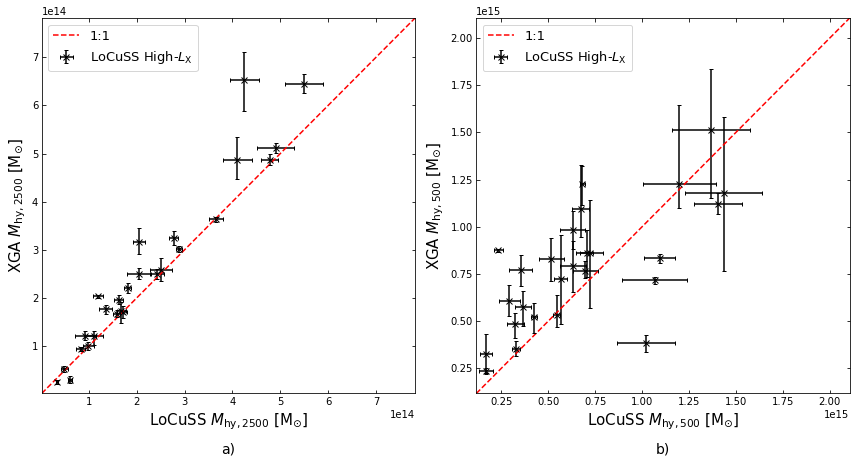

In [10]:
direct_comparison_plot([loc_lit_m2500s, loc_lit_m500s], 
                       [loc_sb_dblbeta_simpvikh_13_m2500, loc_sb_dblbeta_simpvikh_13_m500], 
                       [r"LoCuSS $M_{\rm{hy, 2500}}$ [M$_{\odot}$]", r"LoCuSS $M_{\rm{hy, 500}}$ [M$_{\odot}$]"], 
                       [r"XGA $M_{\rm{hy, 2500}}$ [M$_{\odot}$]", r"XGA $M_{\rm{hy, 500}}$ [M$_{\odot}$]"],
                       r"LoCuSS High-$L_{\rm{X}}$", (12, 6.5), ['linear', 'linear'], ['linear', 'linear'])
# savepath='../../outputs/figures/locussBLAH_comp.pdf'

100%|█████████████████████████████████████████████████████████████████| 30000/30000 [00:26<00:00, 1141.16it/s]


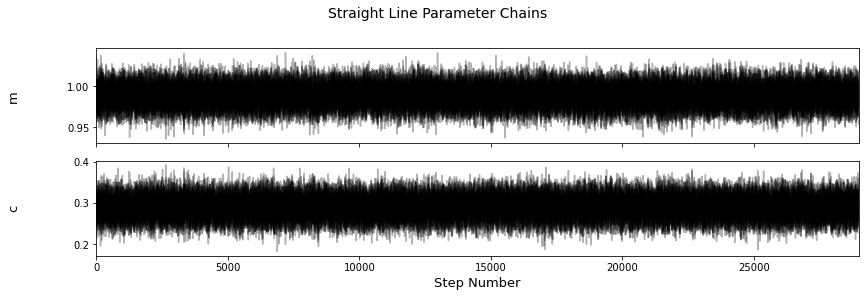

Removed no burn in


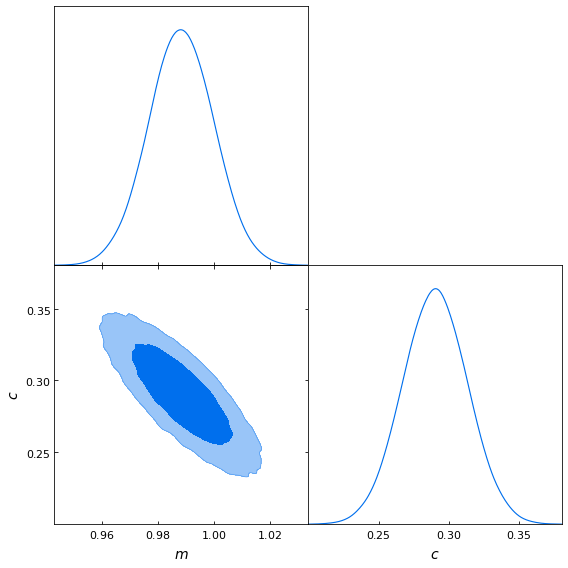

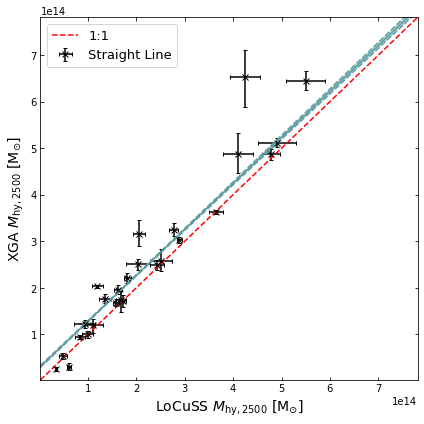

m=0.988 +0.012 -0.012 [1sig]
c=0.29 +0.023 -0.023 [1sig]


In [11]:
fit_comp(loc_lit_m2500s, loc_sb_dblbeta_simpvikh_13_m2500, [[-5, 5], [-5, 5]], 
         r"LoCuSS $M_{\rm{hy, 2500}}$ [M$_{\odot}$]", r"XGA $M_{\rm{hy, 2500}}$ [M$_{\odot}$]", view_chains=True,
         view_corner=True, norm=Quantity(1e+14, 'Msun'), linear=True, xscale='linear', yscale='linear')

  0%|                                                                               | 0/30000 [00:00<?, ?it/s]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/emcee-3.1.1-py3.8.egg/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|█████████████████████████████████████████████████████████████████| 30000/30000 [00:26<00:00, 1131.88it/s]


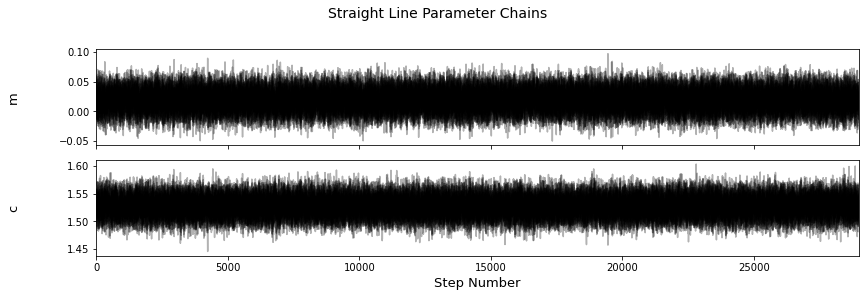

Removed no burn in


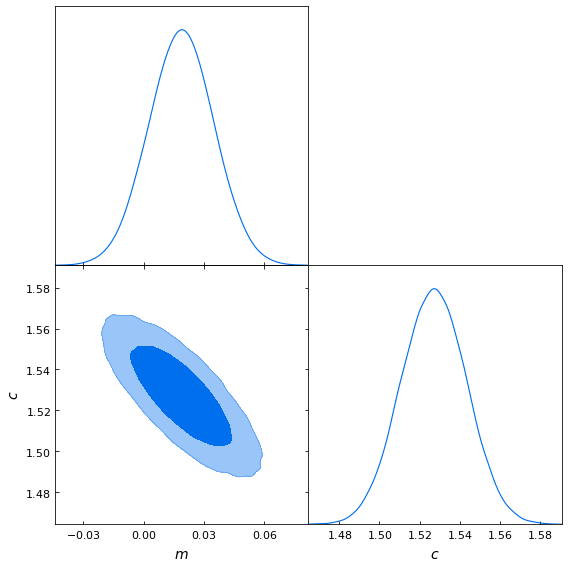

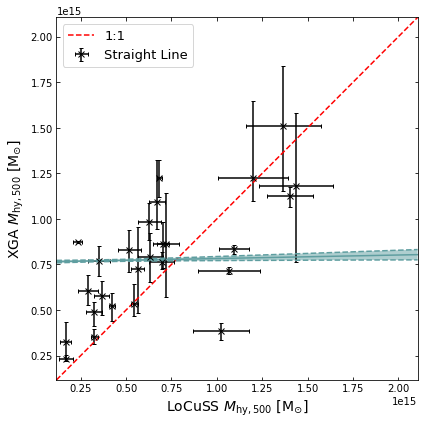

m=0.019 +0.016 -0.016 [1sig]
c=1.527 +0.016 -0.016 [1sig]


In [12]:
fit_comp(loc_lit_m500s, loc_sb_dblbeta_simpvikh_13_m500, [[-5, 5], [-5, 5]], 
         r"LoCuSS $M_{\rm{hy, 500}}$ [M$_{\odot}$]", r"XGA $M_{\rm{hy, 500}}$ [M$_{\odot}$]", view_chains=True,
         view_corner=True, norm=Quantity(5e+14, 'Msun'), linear=True, xscale='linear', yscale='linear')

#### Problematic Cluster

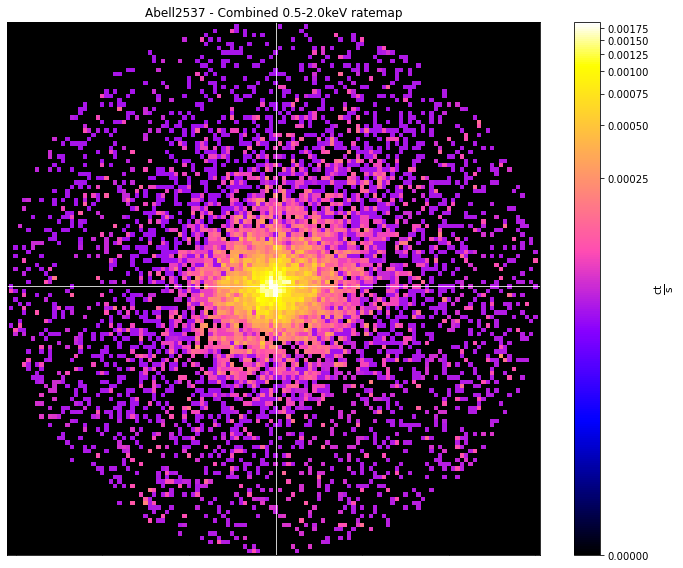

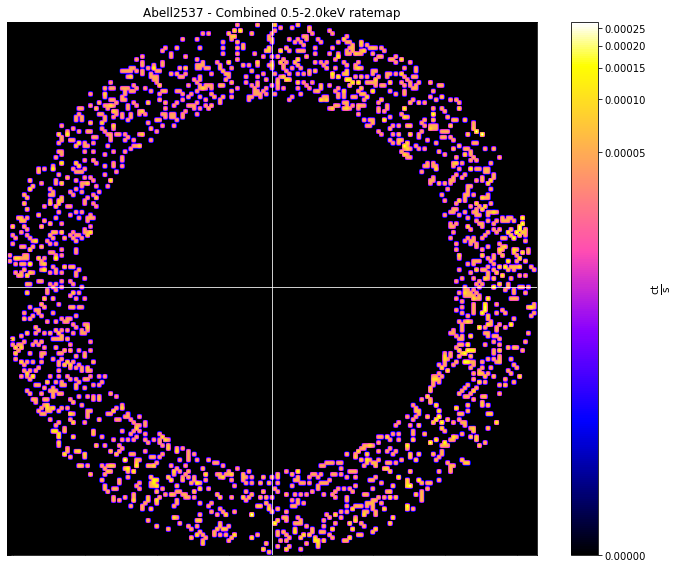

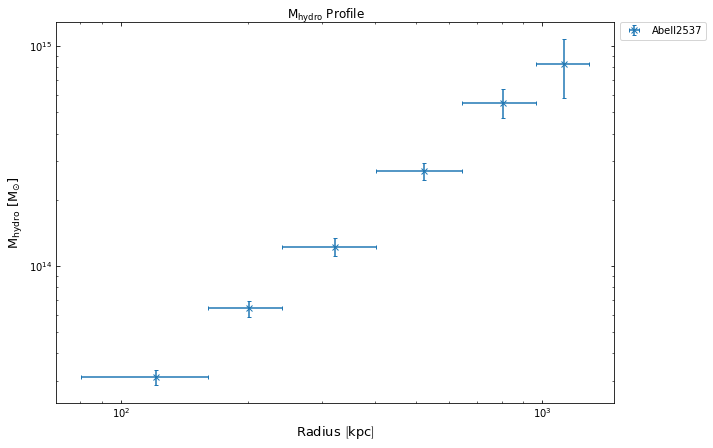

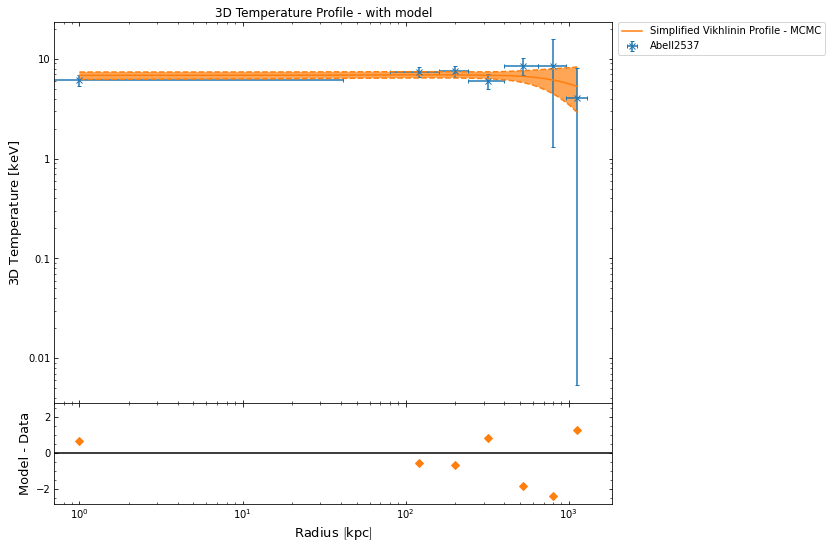

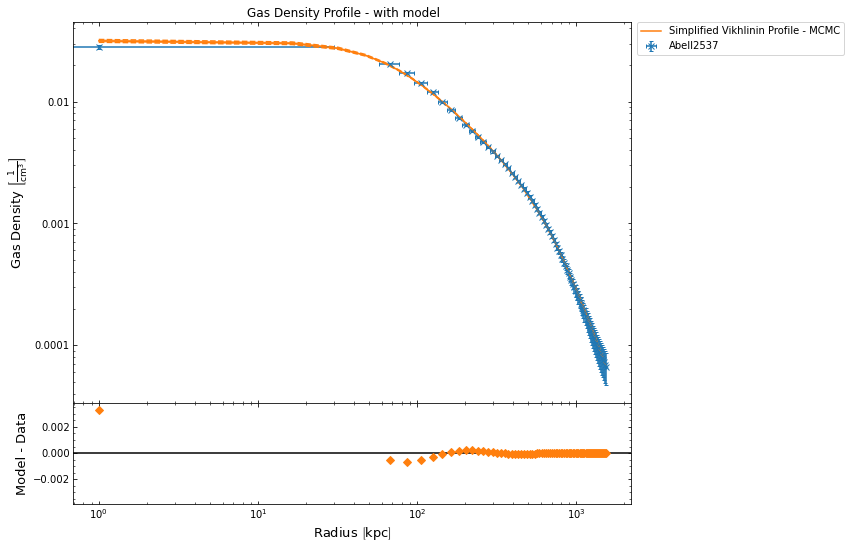


-----------------------------------------------------
Source Name - Abell2537
User Coordinates - (347.092, -2.19122) degrees
X-ray Peak - (347.092, -2.19122) degrees
nH - 0.0545 1e+22 / cm2
Redshift - 0.297
XMM ObsIDs - 1
PN Observations - 1
MOS1 Observations - 1
MOS2 Observations - 1
On-Axis - 1
With regions - 1
Total regions - 35
Obs with 1 detection - 1
Obs with >1 matches - 0
Images associated - 9
Exposure maps associated - 6
Combined Ratemaps associated - 2
Spectra associated - 9
Fitted Models - constant*tbabs*apec | constant*tbabs*apec
R500 - 1180.0 kpc
R500 SNR - 98.47
R2500 - 510.0 kpc
R2500 SNR - 79.2
R500 Tx - 6.94±0.31[keV]
R500 0.5-2.0keV Lx - 3.86±0.065[e+44 erg/s]
-----------------------------------------------------



In [13]:
problem_src = locuss_srcs[42]
problem_mp = loc_sb_dblbeta_simpvikh_13_mp[42]
problem_src.get_combined_ratemaps().view(problem_src.ra_dec, problem_src.get_mask('r500')[0], zoom_in=True)
problem_src.get_combined_ratemaps().view(problem_src.ra_dec, problem_src.get_mask('r500')[1], zoom_in=True)
problem_mp.view()
problem_mp.temperature_profile.view()
problem_mp.density_profile.view()
problem_src.info()

### Double Beta and Simplified Vikhlinin Density/Temperature Profiles - out to 1.2$R_{500}$

In [14]:
loc_sb_dblbeta_simpvikh_12_mp = inv_abel_dens_onion_temp(locuss_srcs, locuss_srcs.r500*1.2, 'double_beta', 
                                                         'simple_vikhlinin_dens', 'simple_vikhlinin_temp', 'r500', 
                                                         temp_min_snr=30, freeze_met=False, 
                                                         temp_lo_en=Quantity(0.7, 'keV'), 
                                                         temp_hi_en=Quantity(10., 'keV'))

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/xspec/run.py:186: UserWarning: All XSPEC operations had already been run.
  warnings.warn("All XSPEC operations had already been run.")
Generating products of type(s) spectrum: 100%|████████████████████████████| 216/216 [1:38:38<00:00, 27.40s/it]
Generating products of type(s) annular spectrum set components: 100%|███| 2767/2767 [2:36:51<00:00,  3.40s/it]
Running XSPEC Fits:   5%|██▊                                                 | 31/574 [00:47<01:39,  5.43it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [15]:
loc_sb_dblbeta_simpvikh_12_m500 = []
loc_sb_dblbeta_simpvikh_12_m2500 = []

with tqdm(desc='Measuring Masses for LoCuSS Clusters', total=len(loc_sb_dblbeta_simpvikh_12_mp)) as onwards:
    for mp in loc_sb_dblbeta_simpvikh_12_mp:
        if mp is not None:
            rel_src = locuss_srcs[mp.src_name]
            m = mp.mass(rel_src.r500)[0]
            if m[0] < Quantity(1e+13, 'Msun'):
                m = Quantity([np.NaN, np.NaN, np.NaN], 'Msun')
                m2500 = Quantity([np.NaN, np.NaN, np.NaN], 'Msun')
            else:
                m2500 = mp.mass(rel_src.r2500)[0]
        else:
            m = Quantity([np.NaN, np.NaN, np.NaN], 'Msun')
            m2500 = Quantity([np.NaN, np.NaN, np.NaN], 'Msun')
            
        loc_sb_dblbeta_simpvikh_12_m500.append(m)
        loc_sb_dblbeta_simpvikh_12_m2500.append(m2500)
        
        onwards.update(1)

loc_sb_dblbeta_simpvikh_12_m500 = Quantity(loc_sb_dblbeta_simpvikh_12_m500)
loc_sb_dblbeta_simpvikh_12_m2500 = Quantity(loc_sb_dblbeta_simpvikh_12_m2500)

Measuring Masses for LoCuSS Clusters:  22%|███████▌                           | 10/46 [00:00<00:00, 41.13it/s]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1521: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Measuring Masses for LoCuSS Clusters: 100%|███████████████████████████████████| 46/46 [00:00<00:00, 48.16it/s]


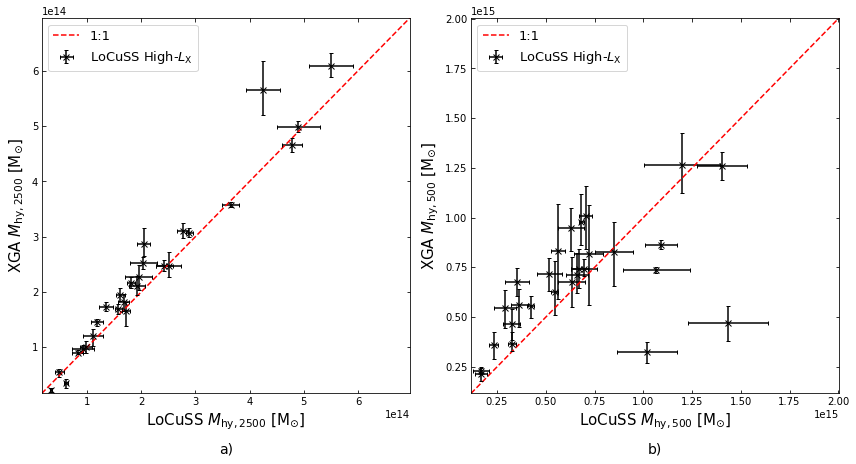

In [16]:
direct_comparison_plot([loc_lit_m2500s, loc_lit_m500s], 
                       [loc_sb_dblbeta_simpvikh_12_m2500, loc_sb_dblbeta_simpvikh_12_m500], 
                       [r"LoCuSS $M_{\rm{hy, 2500}}$ [M$_{\odot}$]", r"LoCuSS $M_{\rm{hy, 500}}$ [M$_{\odot}$]"], 
                       [r"XGA $M_{\rm{hy, 2500}}$ [M$_{\odot}$]", r"XGA $M_{\rm{hy, 500}}$ [M$_{\odot}$]"],
                       r"LoCuSS High-$L_{\rm{X}}$", (12, 6.5), ['linear', 'linear'], ['linear', 'linear'])
# savepath='../../outputs/figures/locussBLAH_comp.pdf'

### Double Beta and Simplified Vikhlinin Density/Temperature Profiles - out to 1.1$R_{500}$

In [18]:
loc_sb_dblbeta_simpvikh_11_mp = inv_abel_dens_onion_temp(locuss_srcs, locuss_srcs.r500*1.1, 'double_beta', 
                                                         'simple_vikhlinin_dens', 'simple_vikhlinin_temp', 'r500', 
                                                         temp_min_snr=30, freeze_met=False, 
                                                         temp_lo_en=Quantity(0.7, 'keV'), 
                                                         temp_hi_en=Quantity(10., 'keV'))

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/xspec/run.py:186: UserWarning: All XSPEC operations had already been run.
  warnings.warn("All XSPEC operations had already been run.")
Generating products of type(s) annular spectrum set components: 100%|███| 1053/1053 [1:05:28<00:00,  3.73s/it]
Running XSPEC Fits: 100%|███████████████████████████████████████████████████| 553/553 [41:20<00:00,  4.48s/it]
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/xspec/run.py:326: UserWarning: Abell0697 annular spectra profile fit was not successful
  warnings.warn("{src} annular spectra profile fit was not successful".format(src=ann_spec.src_name))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/xspec/run.py:326: UserWarning: Abell0963 annular spectra profile fit was not successful
  warnings.warn("{src} annular spectra profile fit was not successful".format(src=ann_spec.src_name))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/xspec/run.py:326: UserWarning: Abell1451 annular spectra profile fit was not succe

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1298.32921429 1358.71253029 1801.96055204 1709.91359947 1740.93558567
 1811.65688645]


Fitting data, inverse Abel transforming, and measuring densities:   5%|▍       | 2/39 [00:52<16:27, 26.69s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [421.81106856 254.31480234 415.98447804 381.25851757 380.13777679
 422.39902174]


Fitting data, inverse Abel transforming, and measuring densities:   8%|▌       | 3/39 [01:17<15:21, 25.61s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1529.19373164  988.54554475 1727.11240102 1411.0970181  1620.01159356
 1828.55903916]


Fitting data, inverse Abel transforming, and measuring densities:  10%|▊       | 4/39 [01:40<14:21, 24.63s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 949.86130733 1898.38983483 1663.82623937 1790.6730562  1858.78988451
 2074.60015247]


Fitting data, inverse Abel transforming, and measuring densities:  13%|█       | 5/39 [02:04<13:56, 24.61s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [274.82412803 441.47121122 150.36540675 118.82037637 199.89720298
 271.2825744 ]


Fitting data, inverse Abel transforming, and measuring densities:  21%|█▋      | 8/39 [03:22<13:07, 25.40s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 248.37876532  484.12969554 2105.09544306 2073.34191955 2114.36452155
 2078.68235204]


Fitting data, inverse Abel transforming, and measuring densities:  33%|██▎    | 13/39 [05:35<11:20, 26.18s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [804.8063285  171.29992245 904.20557267 802.87836019 893.33864446
 893.19944718]


Fitting data, inverse Abel transforming, and measuring densities:  36%|██▌    | 14/39 [06:00<10:50, 26.03s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [776.37196609 794.09161291 764.49933273 807.28572237 838.63556443
 836.73425547]


Fitting data, inverse Abel transforming, and measuring densities:  41%|██▊    | 16/39 [06:52<09:54, 25.84s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 459.0067375   323.53431105 1848.82033518 1364.78500111 1452.03287449
 1625.67256953]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of Abell0781's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  44%|███    | 17/39 [07:15<09:15, 25.25s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 185.97546806 1034.7827102  1943.64138124 2421.97423327 2407.62584812
 1905.68008709]


Fitting data, inverse Abel transforming, and measuring densities:  51%|███▌   | 20/39 [08:41<08:42, 27.49s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of RXCJ1212.3-1816's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  54%|███▊   | 21/39 [09:03<07:44, 25.82s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 383.57849719  569.13461423 1021.86668221 1150.57184071 1093.49901558
 1016.06074461]


Fitting data, inverse Abel transforming, and measuring densities:  56%|███▉   | 22/39 [09:26<07:07, 25.17s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1523.10052966 1044.16471408 2433.22149825 1196.08220258 1682.31177077
 2407.52599271]


Fitting data, inverse Abel transforming, and measuring densities:  62%|████▎  | 24/39 [10:20<06:24, 25.64s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1303.25682996  714.0577139  2164.37962058 1019.72186487 1065.57126995
 2162.48362407]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 625.17928692  781.74656613 1287.41183543 1163.87168571  990.09503926
 1024.92805593]


Fitting data, inverse Abel transforming, and measuring densities:  74%|█████▏ | 29/39 [12:34<04:22, 26.23s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 801.79757949  916.62406348 1706.49084084 1417.68056379 1556.55926463
 1730.89462966]


Fitting data, inverse Abel transforming, and measuring densities:  79%|█████▌ | 31/39 [13:25<03:28, 26.10s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1017.17961782  837.48933265 1001.02647884  898.98476676  945.81441973
 1016.91608575]


Fitting data, inverse Abel transforming, and measuring densities:  95%|██████▋| 37/39 [16:11<00:53, 26.75s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1118.89172919  750.37816511 1220.67950965 1111.05401236 1194.93102147
 1243.2770141 ]


Fitting data, inverse Abel transforming, and measuring densities:  97%|██████▊| 38/39 [16:37<00:26, 26.59s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [688.37076147 563.7827809  773.51574947 534.11042493 653.53885062
 806.44736805]


Fitting data, inverse Abel transforming, and measuring densities: 100%|███████| 39/39 [17:01<00:00, 26.20s/it]


The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [332.45955154 647.83690235 577.21914403 511.67472198 564.04159669
 566.19991046]


Generating Abell2697 hydrostatic mass profile:   0%|                                   | 0/46 [00:00<?, ?it/s]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [596.33687796 788.78632316 502.9549198  486.82542654 560.86331219
 416.01581085]
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 108.92737706  161.95653412 1035.4408773   100.83259446   93.68916078
  630.91059637]


Generating Abell0068 hydrostatic mass profile:   2%|▌                          | 1/46 [00:49<37:25, 49.90s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [818.91112988 763.02243415 610.13794159 692.9803876  832.10489357
 550.67480178]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [156.70410871 226.18931425 627.61663348 118.9937783  129.56501353
 280.29632414]


Generating Abell2813 hydrostatic mass profile:   4%|█▏                         | 2/46 [01:41<37:17, 50.85s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [471.00033536 698.95076209 418.38486433 450.52972143 491.10289468
 458.49616632]


Generating Abell0115S hydrostatic mass profile:   7%|█▋                        | 3/46 [02:29<35:38, 49.73s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1521: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [522.05603051 953.18614708 786.5938114  805.9016502  547.7953198
 731.31552741]
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [278.74811598 299.06330021 444.41568509 262.39580136 211.78322088
 413.7225498 ]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1521: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating Abell141 hydrostatic mass profile:   9%|██▍                         | 4/46 [03:18<34:26, 49.21s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1016.23707668 1106.93239804  822.50878144  998.50712897  841.77105348
  895.53198334]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [126.55410043 250.40007672 705.27501019 122.18582686 102.0412608
 235.58408062]


Generating ZwCl0104.4+0048 hydrostatic mass profile:  11%|██▎                  | 5/46 [04:05<33:15, 48.66s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 924.3350019  1153.30043669  822.10721249  924.18752887  667.18102759
  573.57321736]


Generating Abell0209 hydrostatic mass profile:  13%|███▌                       | 6/46 [04:52<32:01, 48.03s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [  98.11347247   95.50199359 1150.69868162  104.03482401  116.99310691
   96.02531799]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1521: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [412.65609783 607.19536964 583.82643847 749.16912498 397.49638979
 604.15953118]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 702.63690424 1165.46597003 1466.97918147  470.25197032  724.26682009
 1386.48002756]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1521: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating Abell0267 hydrostatic mass profile:  15%|████                       | 7/46 [05:45<32:07, 49.42s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [315.4452669  700.3043901  477.28088935 411.53697278 345.31917852
 401.49051228]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 95.20159026  93.30368412 484.79065653 109.37602341 134.80857846
  98.77486993]


Generating Abell0291 hydrostatic mass profile:  17%|████▋                      | 8/46 [06:33<31:11, 49.26s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1521: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1059.55517083 1964.4653294  2453.57286164 1007.0745442  1523.48297758
 2185.42827054]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 96.53095252  97.92585959 400.37376629  95.98982099 102.289673
  94.64714584]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1521: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating Abell0383 hydrostatic mass profile:  20%|█████▎                     | 9/46 [07:23<30:22, 49.26s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1252.78757127 1731.43386099 1336.86970267 1184.96661041 1577.15261652
  868.45539811]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 86.06431055  86.68360823 961.18476209  78.85541697  76.62026755
  87.57539591]


Generating Abell0521 hydrostatic mass profile:  22%|█████▋                    | 10/46 [08:14<29:56, 49.90s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 593.9966824   700.99958949  790.75790682 1346.09854048  509.46188311
  762.53034211]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1548.45596639 1560.95328297  888.88337675 1107.76391715 1584.58752419
  903.7761365 ]


Generating Abell0586 hydrostatic mass profile:  24%|██████▏                   | 11/46 [09:03<28:57, 49.64s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1521: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [392.81608521 826.47568032 397.57596153 426.95259799 352.04084377
 436.81186203]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 89.32765039  92.68808349 606.48622018  96.07652661 121.35496508
 100.8863791 ]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1521: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating Abell0611 hydrostatic mass profile:  26%|██████▊                   | 12/46 [09:53<28:13, 49.82s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 518.73540546 1064.45510333  545.78723203  420.94196212  402.85734437
  442.42794964]
The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [315.99904351 413.74273113 527.12209073 247.72231943 144.72489522
 459.17849792]


Generating ZwCl0857.9+2107 hydrostatic mass profile:  30%|██████              | 14/46 [10:42<26:19, 49.34s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1030.93726915 1362.29714246  935.94771197  962.29878469  764.80480395
  868.99234683]


Generating Abell0750 hydrostatic mass profile:  33%|████████▍                 | 15/46 [11:28<19:15, 37.28s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 103.10230384  106.97907845 1139.21156369   92.46171416   98.20850514
  132.87355922]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1521: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1153.47422896 1037.81702225 1195.9089331  1074.56840648  917.07747373
  856.40340899]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1521: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating Abell0773 hydrostatic mass profile:  35%|█████████                 | 16/46 [12:15<19:47, 39.57s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1322.28967725 1360.15157192 1163.51570339 1365.45176602  825.75663546
 1200.79743541]
The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [696.99462738 754.43863897 419.19485012 395.29471048 295.50816937
 308.94931403]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 98.83812824  95.60589892 674.00852182 115.39519644 130.77137452
  99.36748696]


Generating Abell0781 hydrostatic mass profile:  37%|█████████▌                | 17/46 [13:04<20:20, 42.09s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/mass.py:221: UserWarning: The density profile for Abell0781 could not be generated
  warn("The density profile for {} could not be generated".format(src.name))
Generating Abell0901 hydrostatic mass profile:  39%|██████████▏               | 18/46 [13:04<19:38, 42.09s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1521: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 855.64211063 1178.22378316  344.98563877  815.96569402  377.16635257
  383.57223513]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 80.15300352  81.00298247 923.38239761  88.64963745  86.64193675
  81.24744118]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1521: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating Abell0907 hydrostatic mass profile:  41%|██████████▋               | 19/46 [13:55<15:47, 35.11s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1162.40535184 1697.31092728 1556.99590757 1533.58900427 1938.05116484
  852.18166157]


Generating ZwCl1021.0+0426 hydrostatic mass profile:  46%|█████████▏          | 21/46 [14:47<16:14, 39.00s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [489.90462977 461.0959455  295.67070304 607.96102163 218.61918656
 207.35474295]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 94.8665329   99.31730687 515.06965738  84.99815452 128.11103275
  77.96674516]


Generating RXCJ1212.3-1816 hydrostatic mass profile:  50%|██████████          | 23/46 [15:38<12:52, 33.60s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/mass.py:221: UserWarning: The density profile for RXCJ1212.3-1816 could not be generated
  warn("The density profile for {} could not be generated".format(src.name))
Generating ZwCl1231.4+1007 hydrostatic mass profile:  52%|██████████▍         | 24/46 [15:38<12:19, 33.60s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1521: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [2095.46471273 1497.55281585 2254.53498401 1590.58106696  609.26301152
 1278.37971985]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1521: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating Abell1689 hydrostatic mass profile:  54%|██████████████▏           | 25/46 [16:28<09:00, 25.75s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1115.92772131 1321.30854829 1069.53455839 1279.66999282  881.150555
  995.98009951]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 78.76472666  81.49788022 834.51986386  80.41292264  84.26370391
  84.50557827]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1521: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating Abell1758N hydrostatic mass profile:  57%|██████████████▏          | 26/46 [17:23<10:19, 30.96s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [505.38602067 689.24892581 522.18394494 682.29906951 480.36510593
 514.25267381]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1649.35002055 1640.40400854  486.59965888 1205.93593535 1651.31320455
  487.24816555]


Generating Abell1763 hydrostatic mass profile:  59%|███████████████▎          | 27/46 [18:12<10:58, 34.67s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1521: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [  91.99056998   95.16178862 1109.19967072  114.39792822  124.42493813
  100.11033526]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1521: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating Abell1835 hydrostatic mass profile:  61%|███████████████▊          | 28/46 [19:02<11:26, 38.15s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1606.83694585 1329.52846198 1407.70858433 1788.37194448  417.66479069
  819.0832646 ]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 78.28437016  83.60886009 403.69507289  81.3641476   64.8943432
  74.29687599]


Generating ZwCl1454.8+2233 hydrostatic mass profile:  65%|█████████████       | 30/46 [19:57<11:15, 42.21s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1411.06613844 1576.55314667 1420.73182737 1095.81691266 1952.05124732
 1214.95028373]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [  97.13998225  105.73906343 1007.42172138   94.19802517  114.49830582
  106.5922218 ]


Generating Abell2009 hydrostatic mass profile:  67%|█████████████████▌        | 31/46 [20:44<08:40, 34.68s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1521: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [369.12802329 450.64206844 527.00080262 252.49048414 274.39999272
 264.15137667]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1521: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating ZwCl1459.4+4240 hydrostatic mass profile:  70%|█████████████▉      | 32/46 [21:40<09:12, 39.48s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [392.74159075 657.25963326 452.27908704 452.99832943 629.72955593
 296.34743869]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1270.18630201 1402.8165722   608.01301948 1193.5116117  1182.1765576
  772.87642053]


Generating RXCJ1504.1-0248 hydrostatic mass profile:  72%|██████████████▎     | 33/46 [22:29<09:01, 41.68s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1521: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1398.20026541 1441.75995835  971.1064336  1448.08218349  629.2184051
 1037.10286796]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [  54.58455957   76.95917132 1073.65848385   88.96236417   87.39932689
   34.84238199]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1521: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating Abell2111 hydrostatic mass profile:  74%|███████████████████▏      | 34/46 [23:23<09:00, 45.00s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [268.95219852 487.63118095 322.35997647 347.16245763 314.3280663
 270.39597884]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 95.57279151 103.99234727 537.73854977  88.63057495  85.37489381
 112.13305738]


Generating Abell2204 hydrostatic mass profile:  76%|███████████████████▊      | 35/46 [24:14<08:30, 46.44s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1521: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1521: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating RXJ1720.1+2638 hydrostatic mass profile:  80%|████████████████▉    | 37/46 [25:13<07:30, 50.05s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [719.79537236 534.17914138 151.96852737 735.18298653 347.90748077
 422.54291025]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 78.9128071   82.97494998 568.24003203  79.62789691  89.58667786
  69.58566971]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1521: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating RXCJ2102.1-2431 hydrostatic mass profile:  85%|████████████████▉   | 39/46 [26:09<04:42, 40.32s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 761.98526636 1010.27866638  565.6026237   535.77357529  665.35953504
  477.45938463]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1521: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating RXJ2129.6+0005 hydrostatic mass profile:  87%|██████████████████▎  | 40/46 [26:58<03:25, 34.24s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1437.60160048 1665.2085182  1289.57163291 1692.37916474  729.18760661
  728.85373252]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 78.84764118  81.3281933  488.68344159  84.26550052  87.67270349
  87.16849681]


Generating Abell2390 hydrostatic mass profile:  89%|███████████████████████▏  | 41/46 [27:49<03:09, 37.88s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [509.25933832 391.35021677 374.92852275 372.74045139 226.19791357
 216.58544385]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 89.86113642  85.04179065 481.55970659  88.08833706  85.47280892
  80.48722235]


Generating Abell2537 hydrostatic mass profile:  91%|███████████████████████▋  | 42/46 [28:44<02:47, 41.81s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [311.0226377  631.56674726 426.66403654 460.98838426 316.58055358
 305.57639748]


Generating Abell2552 hydrostatic mass profile:  93%|████████████████████████▎ | 43/46 [29:34<02:11, 43.83s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 503.02461195  745.47568925 1042.98445144  303.30182206  154.73770136
  851.07884044]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [544.77158797 761.95974131 605.16324156 603.38192612 529.15761872
 557.73666709]


Generating Abell2645 hydrostatic mass profile:  98%|█████████████████████████▍| 45/46 [30:24<00:45, 45.48s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [562.47097896 520.7802624  426.95080694 488.56272498 360.27880327
 388.84111508]


Complete: 100%|███████████████████████████████████████████████████████████████| 46/46 [31:13<00:00, 40.73s/it]


In [19]:
loc_sb_dblbeta_simpvikh_11_m500 = []
loc_sb_dblbeta_simpvikh_11_m2500 = []

with tqdm(desc='Measuring Masses for LoCuSS Clusters', total=len(loc_sb_dblbeta_simpvikh_11_mp)) as onwards:
    for mp in loc_sb_dblbeta_simpvikh_11_mp:
        if mp is not None:
            rel_src = locuss_srcs[mp.src_name]
            m = mp.mass(rel_src.r500)[0]
            if m[0] < Quantity(1e+13, 'Msun'):
                m = Quantity([np.NaN, np.NaN, np.NaN], 'Msun')
                m2500 = Quantity([np.NaN, np.NaN, np.NaN], 'Msun')
            else:
                m2500 = mp.mass(rel_src.r2500)[0]
        else:
            m = Quantity([np.NaN, np.NaN, np.NaN], 'Msun')
            m2500 = Quantity([np.NaN, np.NaN, np.NaN], 'Msun')
            
        loc_sb_dblbeta_simpvikh_11_m500.append(m)
        loc_sb_dblbeta_simpvikh_11_m2500.append(m2500)
        
        onwards.update(1)

loc_sb_dblbeta_simpvikh_11_m500 = Quantity(loc_sb_dblbeta_simpvikh_11_m500)
loc_sb_dblbeta_simpvikh_11_m2500 = Quantity(loc_sb_dblbeta_simpvikh_11_m2500)

Measuring Masses for LoCuSS Clusters:   9%|███▏                                | 4/46 [00:00<00:01, 37.12it/s]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1521: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Measuring Masses for LoCuSS Clusters: 100%|███████████████████████████████████| 46/46 [00:00<00:00, 46.94it/s]


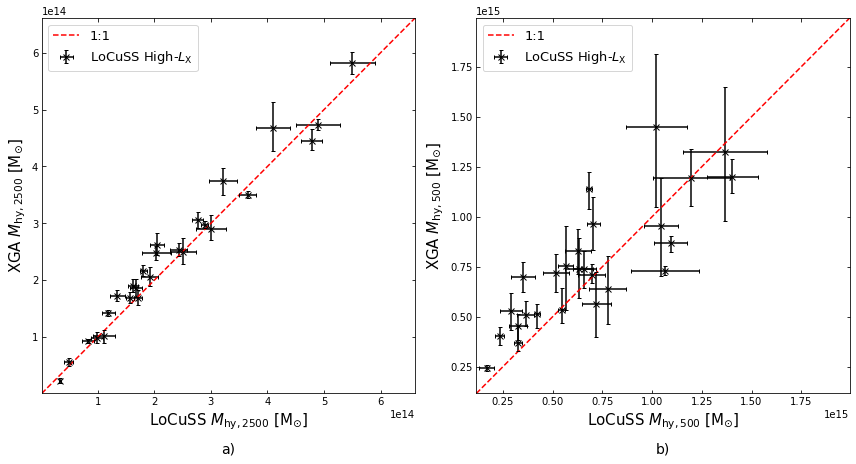

In [20]:
direct_comparison_plot([loc_lit_m2500s, loc_lit_m500s], 
                       [loc_sb_dblbeta_simpvikh_11_m2500, loc_sb_dblbeta_simpvikh_11_m500], 
                       [r"LoCuSS $M_{\rm{hy, 2500}}$ [M$_{\odot}$]", r"LoCuSS $M_{\rm{hy, 500}}$ [M$_{\odot}$]"], 
                       [r"XGA $M_{\rm{hy, 2500}}$ [M$_{\odot}$]", r"XGA $M_{\rm{hy, 500}}$ [M$_{\odot}$]"],
                       r"LoCuSS High-$L_{\rm{X}}$", (12, 6.5), ['linear', 'linear'], ['linear', 'linear'], 
                       savepath='../../outputs/figures/loc_sb_dblbeta_simpvikh_1.1r500_hymcomp.pdf')